In [132]:
import os
import os.path as op
import numpy as np

from tqdm import tqdm

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import json

In [73]:
orig_root = '../../../../datasets/coco_ocr_en_frcn_features/trainval2014'

coco_root = '../../../../datasets/coco_2014/images/' #trainval2014'
coco_train_root = op.join(coco_root, 'train2014')
coco_val_root = op.join(coco_root, 'val2014')

In [74]:
npy_files = sorted(os.listdir(orig_root))

jpg_files_train = {f[:-4]: op.join(coco_train_root, f) for f in os.listdir(coco_train_root)}
jpg_files_val = {f[:-4]: op.join(coco_val_root, f) for f in os.listdir(coco_val_root)}

jpg_files = dict()
jpg_files.update(jpg_files_train)
jpg_files.update(jpg_files_val)

files[0]
# list(jpg_files.keys())[:10]

'COCO_train2014_000000000009.npy'

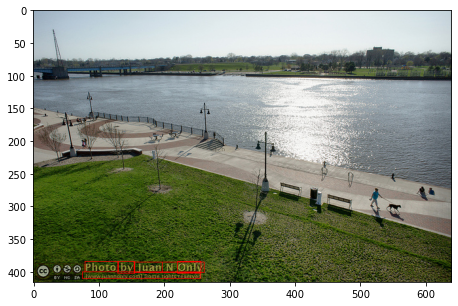

In [90]:
# check some image

for filename in npy_files[35:37:2]:
    f_data = np.load(op.join(orig_root, filename), allow_pickle=True).item()
    boxes = f_data['ocr_boxes']
    tokens = f_data['ocr_tokens']
    im = Image.open(jpg_files[filename[:-9]])

plt.figure(figsize=(8,5))
draw = ImageDraw.Draw(im)

for bbox in boxes:
    b = list(np.asarray(bbox))
    draw.rectangle(b, outline=255)
    
plt.imshow(im);

In [131]:
# Process all images

all_data = []

for filename in tqdm(npy_files[1::2]):
    image_id = filename[-21:-9].lstrip('0')

    f_data = np.load(op.join(orig_root, filename), allow_pickle=True).item()
    boxes = f_data['ocr_boxes']
    tokens = f_data['ocr_tokens']

    if len(boxes) == 0:
        all_data.append({'image_id': image_id, 'data': []})
        continue
        
    im = Image.open(jpg_files[filename[:-9]])
    
    # Make boxes coords relative and add width & height info
    boxes_rel = boxes / np.asarray([im.width, im.height, im.width, im.height])
    b_widths = boxes_rel[:, 2:3] - boxes_rel[:, 0:1]
    b_heights = boxes_rel[:, 3:4] - boxes_rel[:, 1:2]
    boxes_rel_wh = np.hstack((boxes_rel, b_widths, b_heights))
    
    ocr_data = [[list(bbox), token, 1.0] for (bbox, token) in zip(boxes_rel_wh, tokens)]    
    all_data.append({'image_id': image_id, 'data': ocr_data})

all_data[0]

100%|██████████| 123287/123287 [12:54<00:00, 159.12it/s]


{'image_id': '9', 'data': []}

In [ ]:
json_filename = op.join(coco_root, 'ocr_rosetta.json')

with open(json_filename, 'w') as outfile:
    json.dump(all_data, outfile)